In [1]:
from transformers import GPT2LMHeadModel

/home/htkumar/local/miniconda3/envs/gpt-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

sys.path.append("/home/htkumar/llms/gpt2_karpathy")

In [23]:
import os

import matplotlib.pyplot as plt

import tiktoken

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from model import GPT, GPTConfig

%matplotlib inline

In [4]:
device = "cuda"
experiment_id = "base_gpt2"
LOGS_DIR = f"/home/htkumar/llms/gpt2_karpathy/logs_{experiment_id}"
step = 19072

In [5]:
model = GPT(GPTConfig(vocab_size=50304))
model.to(device)
model = torch.compile(model)
checkpoint_file = torch.load(os.path.join(LOGS_DIR, f"model_{step:05d}.pt"))
model.load_state_dict(checkpoint_file["model"])

<All keys matched successfully>

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [7]:
def generate_from_model(model):
    # generate from the model
    num_return_sequences = 5
    max_length = 32
    enc = tiktoken.get_encoding("gpt2")
    tokens = enc.encode("Hello, I'm a language model,")
    tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11]
    tokens = torch.tensor(tokens, dtype=torch.long)  # (8,)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)  # (5, 8)
    x = tokens.to(device)

    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(42)

    # (B, T)
    while x.size(1) < max_length:
        with torch.no_grad():
            # (B, T, vocab_size)
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(x)
            # (B, vocab_size)
            # print(logits.shape)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)

            # (B, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            new_id = torch.multinomial(topk_probs, num_samples=1)  # (B, 1)
            new_id = torch.gather(topk_indices, -1, new_id)  # (B, 1)
            # (B, T + 1)
            x = torch.cat((x, new_id), dim=-1)

    for i in range(num_return_sequences):
        decoded = enc.decode(x[i].tolist())
        print(f"{i} {decoded}")

In [8]:
def generate_from_hf_model(model):
    # generate from the model
    num_return_sequences = 5
    max_length = 32
    enc = tiktoken.get_encoding("gpt2")
    tokens = enc.encode("Hello, I'm a language model,")
    tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11]
    tokens = torch.tensor(tokens, dtype=torch.long)  # (8,)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)  # (5, 8)
    x = tokens.to(device)

    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(42)

    # (B, T)
    while x.size(1) < max_length:
        with torch.no_grad():
            # (B, T, vocab_size)
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits = model(x)[0]
            # (B, vocab_size)
            # print(logits.shape)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)

            # (B, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            new_id = torch.multinomial(topk_probs, num_samples=1)  # (B, 1)
            new_id = torch.gather(topk_indices, -1, new_id)  # (B, 1)
            # (B, T + 1)
            x = torch.cat((x, new_id), dim=-1)

    for i in range(num_return_sequences):
        decoded = enc.decode(x[i].tolist())
        print(f"{i} {decoded}")

In [9]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()
sd_hf.keys()

/home/htkumar/local/miniconda3/envs/gpt-2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


odict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.

In [14]:
model_hf.eval()
model_hf.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
generate_from_hf_model(model_hf)

0 Hello, I'm a language model, and I do not want to spend much time studying in English. (Or in any language.) This book makes me very
1 Hello, I'm a language model, not a problem solver. I find it really surprising that in many games there are a lot of characters, and you
2 Hello, I'm a language model, not a designer," he writes. "I love reading and doing what I do best."

Yet, while the
3 Hello, I'm a language model, you said. You're talking to me, yeah?

The only reason for it is that most people who play
4 Hello, I'm a language model, so I can say that every single program I write as a Java programmer was written from a programming language, but we can


In [ ]:
generate_from_model(model)

In [ ]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

In [ ]:
for k, v in sd_hf.items():
    print(k, v.shape)

In [ ]:
sd_hf["transformer.wpe.weight"].shape

In [ ]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

In [ ]:
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 0])

In [ ]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")

In [ ]:
# from transformers import pipeline, set_seed

# generator = pipeline("text-generation", model="gpt2")
# set_seed(42)
# generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

In [ ]:
# check impact of gradient accumulation

net = nn.Sequential(
    nn.Linear(16, 32),
    nn.GELU(),
    nn.Linear(32, 1),
)

torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)

loss = F.mse_loss(yhat, y)
loss.backward()
net[0].weight.grad.view(-1)[:10]

In [ ]:
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = F.mse_loss(yhat, y[i])
    loss /= 4
    loss.backward()

net[0].weight.grad.view(-1)[:10]

In [ ]:
# analyze the logfile generated after initial training

In [29]:
# calculate validation loss of gpt2 from hf to serve as baseline
from dataloader import DataLoaderLite

val_dataloader = DataLoaderLite(
    B=16, T=1024, process_rank=0, num_processes=1, split="val"
)

found 1 for split val


In [30]:
from tqdm import tqdm

In [31]:
# evaluate gpt-2 baseline model
val_dataloader.reset()
with torch.no_grad():
    val_loss_accum = 0.0
    val_loss_steps = 100
    loss_total = 0.0
    for _ in tqdm(range(val_loss_steps), desc="Evaluating validation loss"):
        x, y = val_dataloader.next_batch()
        x, y = x.to(device), y.to(device)
        logits = model_hf(x)[0]
        # print(logits.size()[-1])
        loss = F.cross_entropy(logits.view(-1, logits.size()[-1]), y.view(-1))
        loss_total += loss.detach()

    loss_avg = loss_total / val_loss_steps
    print(loss_avg)

Evaluating validation loss: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


tensor(3.2758, device='cuda:0')


In [33]:
val_dataloader.reset()
with torch.no_grad():
    val_loss_accum = 0.0
    val_loss_steps = 100
    loss_total = 0.0
    for _ in tqdm(range(val_loss_steps), desc="Evaluating validation loss"):
        x, y = val_dataloader.next_batch()
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # print(logits.size()[-1])
        # loss = F.cross_entropy(logits.view(-1, logits.size()[-1]), y.view(-1))
        loss_total += loss.detach()

    loss_avg = loss_total / val_loss_steps
    print(loss_avg)

Evaluating validation loss: 100%|██████████| 100/100 [00:03<00:00, 33.09it/s]


tensor(3.0829, device='cuda:0')


In [16]:
import numpy as np

sz = "124M"
loss_baseline = {
    "124M": 3.2758,
}[sz]

with open(f"{LOGS_DIR}/log.txt", "r") as f:
    lines = f.readlines()

len(lines)

19113

In [17]:
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

In [18]:
len(streams.keys())

2

In [24]:
streams_xy = {}
for k, v in streams.items():
    xy = sorted(list(v.items()))
    # print(xy)
    # print(zip(*xy))
    streams_xy[k] = list(zip(*xy))

In [25]:
plt.figure(figsize=(16, 6))

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

In [26]:
xs, ys = streams_xy["train"]
ys = np.array(ys)
print(f"min train loss {min(ys)}")

xs_val, ys_val = streams_xy["val"]
ys_val = np.array(ys_val)
print(f"min val loss {min(ys_val)}")

min train loss 2.8671
min val loss 3.0742


Text(0.5, 1.0, 'Loss curve')

findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


findfont: Font family 'Noto Sans TC' not found.


findfont: Font family 'Noto Sans SC' not found.


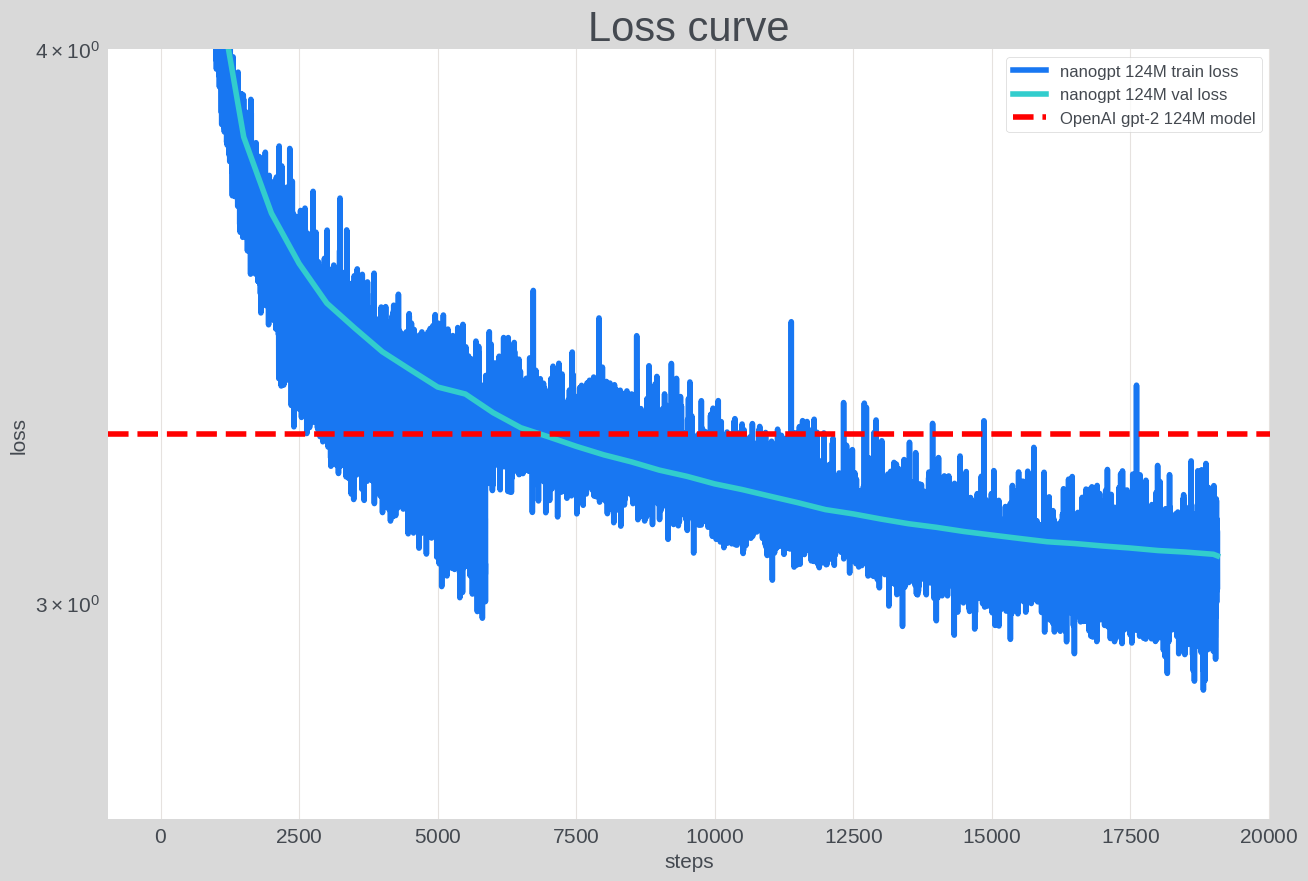

In [27]:
plt.plot(xs, ys, label=f"nanogpt {sz} train loss")
plt.plot(xs_val, ys_val, label=f"nanogpt {sz} val loss")

if loss_baseline is not None:
    plt.axhline(
        y=loss_baseline, color="r", linestyle="--", label=f"OpenAI gpt-2 {sz} model"
    )

plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale("log")
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss curve")

In [ ]:
a = [(1, 2), (2, 3), (3, 4)]
b = list(zip(*a))
b

In [ ]:
a = [1, 2, 3, 4]
b = [2, 3, 4, 5]
for i, j in zip(a, b):
    print(i, j)